In [ ]:
# End-to-end ML pipeline for the Aswan weather -> Solar(PV) dataset by Dr.Anter

# ======================================================
# Cell 1 - Imports and configuration
# Explain: import required libraries and set up helper functions/paths
# ======================================================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

# Note: caas_jupyter_tools is available in the execution environment used earlier. If you run locally, remove tools calls
try:
    import caas_jupyter_tools as tools
    HAVE_TOOLS = True
except Exception:
    HAVE_TOOLS = False

PLOT_DIR = Path("/content/analysis_plotss")
PLOT_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_CSV = Path("/content/Summary")

print("Libraries imported, plot directory:", PLOT_DIR)


Libraries imported, plot directory: /content/analysis_plotss


In [ ]:
# ======================================================
# Cell 2 - Load dataset and quick preview
# Explain: load the CSV you previously uploaded and show a preview and basic shape.
# ======================================================
data_path = Path("/content/AswanData_weatherdata.csv")
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please upload AswanData_weatherdata.csv to /mnt/data/")

df = pd.read_csv(data_path)

print(f"Loaded dataset: {data_path}")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
if HAVE_TOOLS:
    tools.display_dataframe_to_user("Dataset preview (first 50 rows)", df.head(50))
else:
    print(df.head())

Loaded dataset: /content/AswanData_weatherdata.csv
Shape: (398, 7)
Columns: ['Date', 'AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure', 'Solar(PV)']
       Date  AvgTemperture  AverageDew(point via humidity)  Humidity  Wind  \
0  4/1/2022           87.9                            31.3      13.4   5.7   
1  4/3/2022           90.2                            34.0      14.2   6.6   
2  4/4/2022           93.2                            31.4      11.8   8.8   
3  4/5/2022           92.5                            24.9       9.4   8.0   
4  4/6/2022           91.2                            18.9       7.8   9.4   

   Pressure  Solar(PV)  
0      29.2  19.010857  
1      29.1  16.885714  
2      29.1  19.627429  
3      29.1  18.929429  
4      29.2  18.934000  


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns detected:", num_cols)

possible_targets = ["Solar(PV)", "PV_Output", "PV", "Power", "Output", "Energy", "Generation", "pv_output"]
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break

if target_col is None:
    for c in df.columns:
        if any(s in c.lower() for s in ["pv", "solar", "power", "output"]):
            target_col = c
            break

created_proxy = False
if target_col is None:
    if len(num_cols) > 0:
        target_col = df[num_cols].var().idxmax()
        created_proxy = True
        print(f"No explicit 'PV' column found; using '{target_col}' as proxy target.")
    else:
        raise ValueError("No numeric columns found to use as target or features.")

print("Selected target column:", target_col)

if pd.api.types.is_numeric_dtype(df[target_col]):
    median_val = df[target_col].median()
    df["__target_binary__"] = (df[target_col] > median_val).astype(int)
    target = "__target_binary__"
    print(f"Created binary target from '{target_col}' using median={median_val:.4f}.")
else:
    df["__target_binary__"] = df[target_col].astype('category').cat.codes
    target = "__target_binary__"
    print(f"Converted categorical target '{target_col}' to numeric codes.")

if HAVE_TOOLS:
    tools.display_dataframe_to_user("Sample with binary target column", df[[target_col, target]].head(20))
else:
    print(df[[target_col, target]].head())


Numeric columns detected: ['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure', 'Solar(PV)']
Selected target column: Solar(PV)
Created binary target from 'Solar(PV)' using median=23.4760.
   Solar(PV)  __target_binary__
0  19.010857                  0
1  16.885714                  0
2  19.627429                  0
3  18.929429                  0
4  18.934000                  0


In [ ]:
# ======================================================
# Cell 4 - Missing values treatment and basic cleaning
# Explain: show missing values, impute numeric columns with median and categorical with mode.
# ======================================================
missing_before = df.isna().sum()
print("Missing values per column (before imputation):")
print(missing_before[missing_before > 0])

for c in df.columns:
    if df[c].isna().sum() > 0:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c].fillna(df[c].median(), inplace=True)
        else:
            df[c].fillna(df[c].mode().iloc[0], inplace=True)

missing_after = df.isna().sum().sum()
print(f"Total missing values after imputation: {missing_after}")

Missing values per column (before imputation):
Series([], dtype: int64)
Total missing values after imputation: 0


In [ ]:
# ======================================================
# Cell 5 - Descriptive statistics (min, max, mean, var, std, skew, kurtosis)
# Explain: compute and display core descriptive statistics for numeric features.
# ======================================================
stats_df = df[num_cols].agg(['min','max','mean','var','std']).transpose()
stats_df['skewness'] = df[num_cols].skew()
stats_df['kurtosis'] = df[num_cols].kurtosis()
if HAVE_TOOLS:
    tools.display_dataframe_to_user("Descriptive statistics", stats_df.round(6))
else:
    print(stats_df.round(6))

                                      min         max       mean         var  \
AvgTemperture                   51.100000  102.700000  81.846482  185.316398   
AverageDew(point via humidity)  15.300000   63.900000  36.754020   79.331709   
Humidity                         7.400000   47.700000  22.968090   95.191196   
Wind                             4.400000   17.100000  10.146734    6.295846   
Pressure                        28.900000   29.600000  29.183040    0.019668   
Solar(PV)                        8.581429   40.038857  24.375258   56.363466   

                                      std  skewness  kurtosis  
AvgTemperture                   13.613097 -0.528708 -0.903930  
AverageDew(point via humidity)   8.906835  0.001333 -0.667801  
Humidity                         9.756598  0.731028 -0.414197  
Wind                             2.509152  0.223224 -0.182979  
Pressure                         0.140241  0.448676 -0.633823  
Solar(PV)                        7.507561  0.108514 -1.

                                AvgTemperture  AverageDew(point via humidity)  \
AvgTemperture                        1.000000                        0.463094   
AverageDew(point via humidity)       0.463094                        1.000000   
Humidity                            -0.734584                        0.226505   
Wind                                 0.132238                        0.347271   
Pressure                            -0.785056                       -0.290647   
Solar(PV)                            0.036084                       -0.076150   

                                Humidity      Wind  Pressure  Solar(PV)  
AvgTemperture                  -0.734584  0.132238 -0.785056   0.036084  
AverageDew(point via humidity)  0.226505  0.347271 -0.290647  -0.076150  
Humidity                        1.000000  0.090119  0.635229  -0.108118  
Wind                            0.090119  1.000000  0.020762   0.167475  
Pressure                        0.635229  0.020762  1.000000  

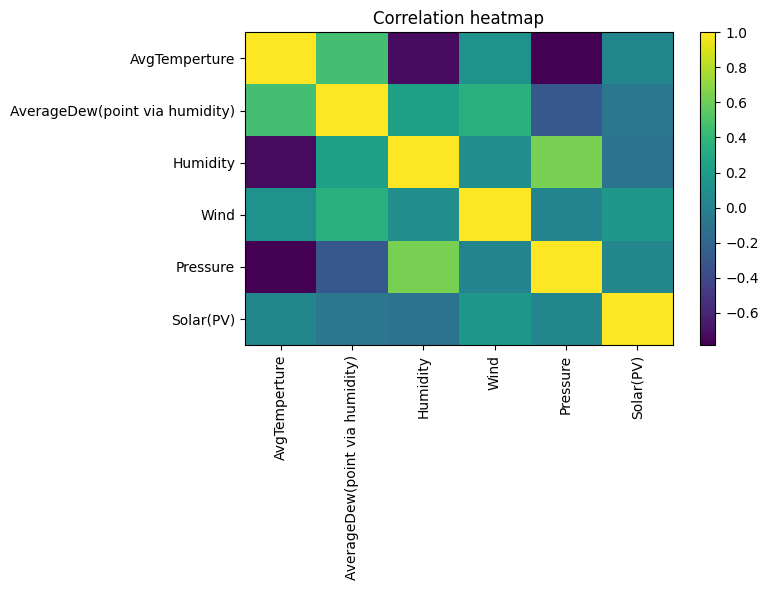

Saved correlation heatmap to /content/analysis_plotss/corr_heatmap.png


In [ ]:
# ======================================================
# Cell 6 - Covariance, correlation, and heatmap
# Explain: covariance and Pearson correlation matrices help find linear relationships.
# ======================================================
cov_mat = df[num_cols].cov()
corr_mat = df[num_cols].corr()

if HAVE_TOOLS:
    tools.display_dataframe_to_user("Covariance matrix", cov_mat.round(6))
    tools.display_dataframe_to_user("Correlation matrix", corr_mat.round(6))
else:
    print(corr_mat.round(6))

plt.figure(figsize=(8,6))
plt.imshow(corr_mat, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()
plt.close()
print("Saved correlation heatmap to", PLOT_DIR/"corr_heatmap.png")


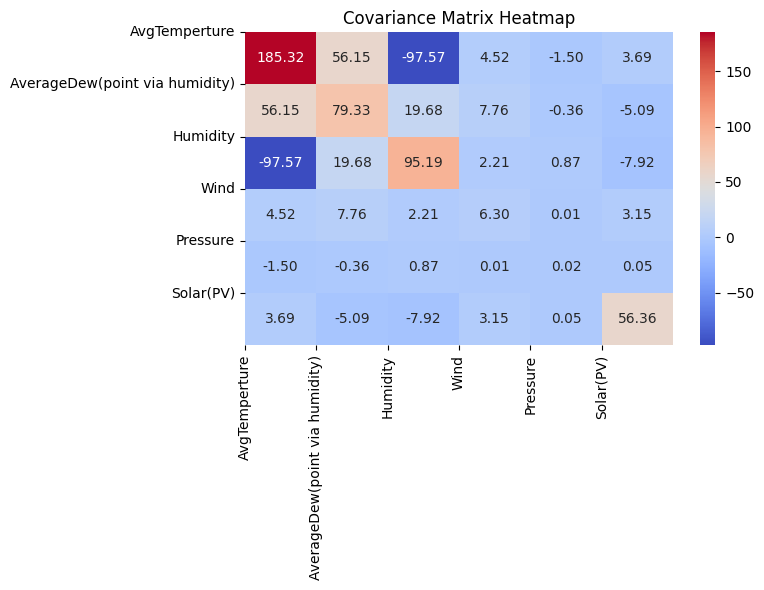

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cov_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()
plt.close()

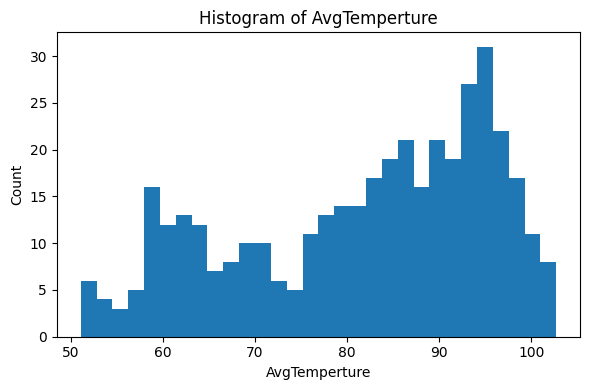

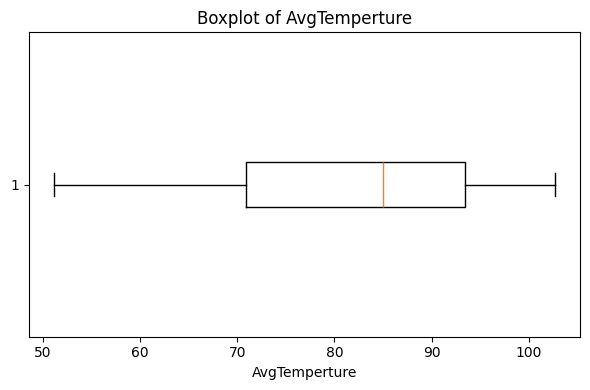

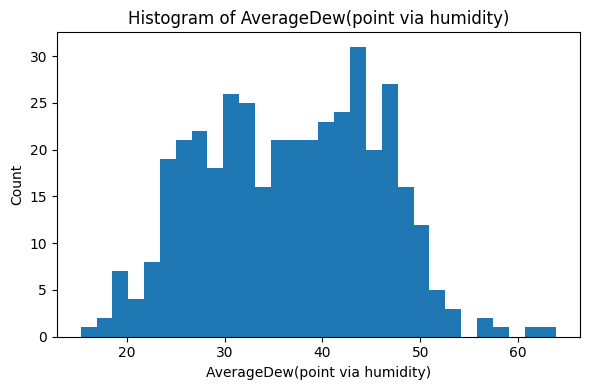

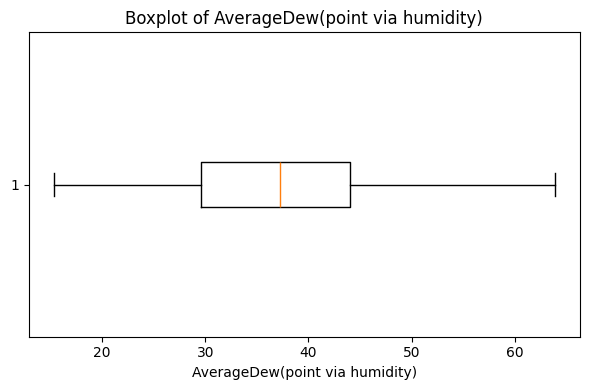

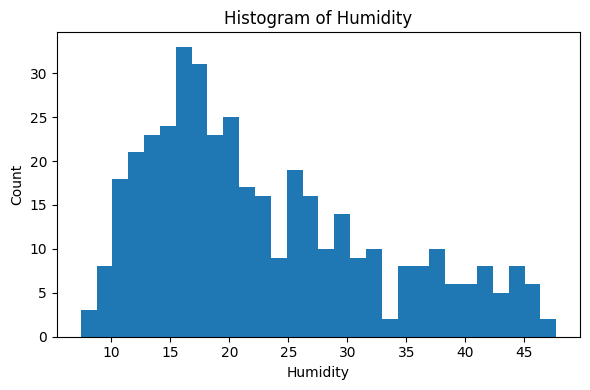

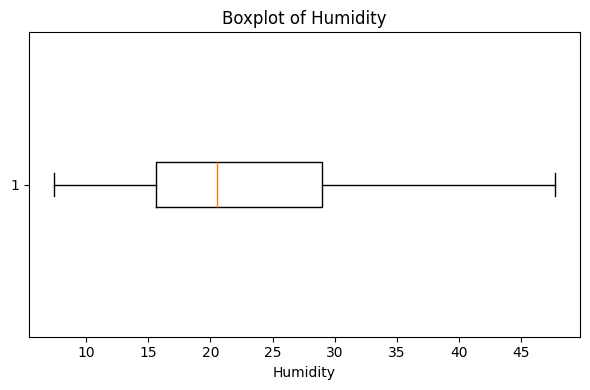

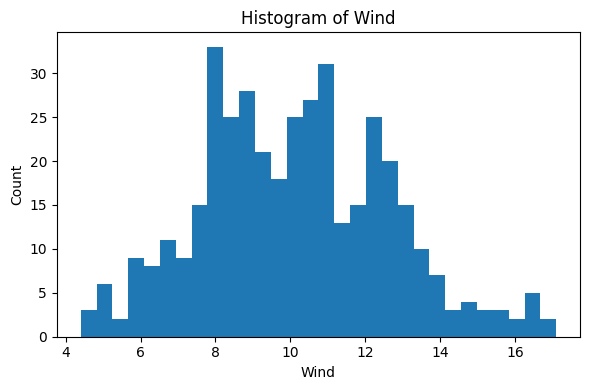

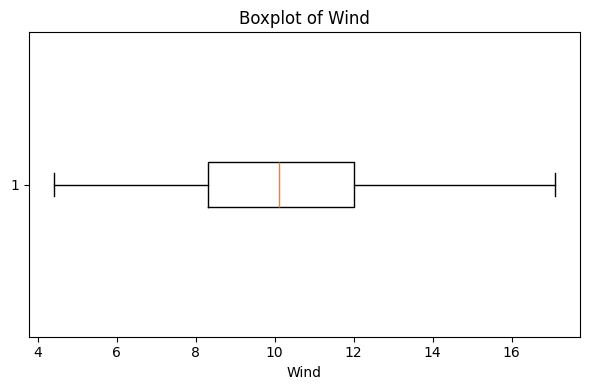

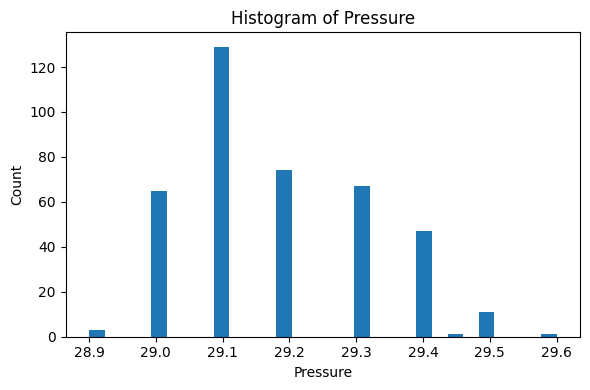

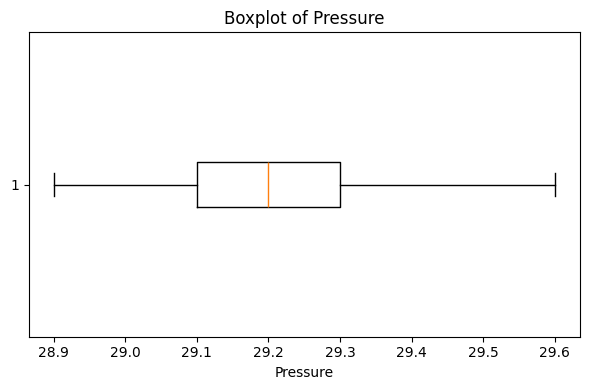

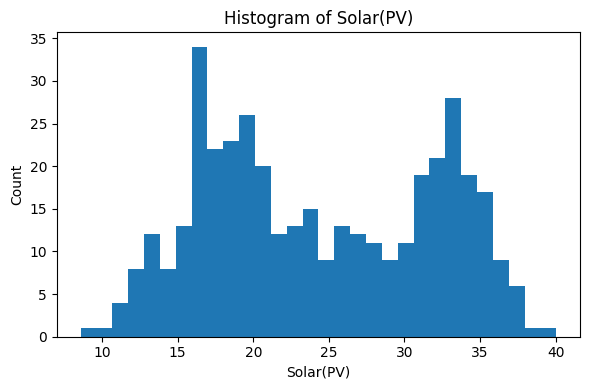

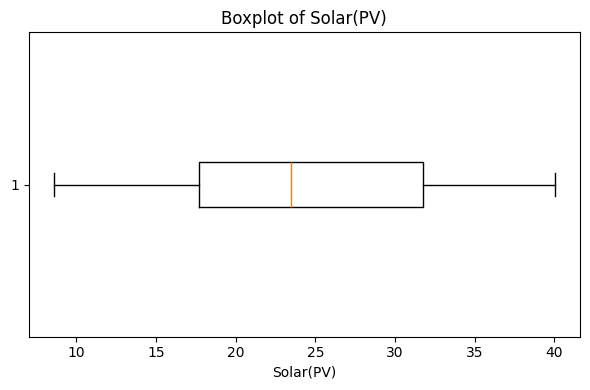

Saved histograms and boxplots to /content/analysis_plotss


In [ ]:
# ======================================================
# Cell 7 - Visualizations: histograms and boxplots for numeric columns
# Explain: distribution and outlier inspection for each numeric feature.
# ======================================================
for c in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f"Histogram of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure(figsize=(6,4))
    plt.boxplot(df[c].dropna(), vert=False)
    plt.title(f"Boxplot of {c}")
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()
    plt.close()

print("Saved histograms and boxplots to", PLOT_DIR)


In [ ]:
# ======================================================
# Cell 8 - Binning (quartiles) and Chi-square test between binned features and binary target
# Explain: bin continuous variables into quartiles to run categorical chi-square tests vs the target.
# ======================================================
from scipy.stats import chi2_contingency
binned = {}
for c in num_cols:
    try:
        binned[c] = pd.qcut(df[c].rank(method='first'), q=4, labels=False, duplicates='drop')
    except Exception:
        binned[c] = pd.Series([0]*len(df), index=df.index)

binned_df = pd.DataFrame(binned)
if HAVE_TOOLS:
    tools.display_dataframe_to_user("Sample of binned features (quartiles)", binned_df.head(20))
else:
    print(binned_df.head())

chi_results = {}
for c in num_cols:
    try:
        cont = pd.crosstab(binned_df[c], df[target])
        chi2, p, dof, ex = chi2_contingency(cont)
        chi_results[c] = (chi2, p)
    except Exception as e:
        chi_results[c] = (np.nan, np.nan)

chi_df = pd.DataFrame.from_dict(chi_results, orient='index', columns=['chi2','pvalue']).sort_values('pvalue')
if HAVE_TOOLS:
    tools.display_dataframe_to_user("Chi-square test results (binned feature vs binary target)", chi_df.round(6))
else:
    print(chi_df.round(6))


   AvgTemperture  AverageDew(point via humidity)  Humidity  Wind  Pressure  \
0              2                               1         0     0         1   
1              2                               1         0     0         0   
2              2                               1         0     1         0   
3              2                               0         0     0         0   
4              2                               0         0     1         1   

   Solar(PV)  
0          1  
1          0  
2          1  
3          1  
4          1  
                                      chi2    pvalue
Solar(PV)                       398.000000  0.000000
AvgTemperture                    21.627475  0.000078
AverageDew(point via humidity)   21.167677  0.000097
Pressure                         12.987475  0.004664
Wind                              7.298990  0.062955
Humidity                          4.444444  0.217300


In [ ]:
# ======================================================
# Cell 9 - T-tests (compare means for the two target classes)
# Explain: independent t-test checks if feature mean differs between the two classes.
# ======================================================
t_results = {}
for c in num_cols:
    try:
        grp0 = df[df[target]==0][c]
        grp1 = df[df[target]==1][c]
        tstat, p = stats.ttest_ind(grp0, grp1, nan_policy='omit', equal_var=False)
        t_results[c] = (tstat, p)
    except Exception as e:
        t_results[c] = (np.nan, np.nan)

t_df = pd.DataFrame.from_dict(t_results, orient='index', columns=['t-stat','pvalue']).sort_values('pvalue')
if HAVE_TOOLS:
    tools.display_dataframe_to_user("T-test results (feature mean difference between classes)", t_df.round(6))
else:
    print(t_df.round(6))


                                   t-stat    pvalue
Solar(PV)                      -37.408218  0.000000
Wind                            -3.363022  0.000846
Pressure                        -1.018706  0.308966
Humidity                         1.004411  0.315794
AvgTemperture                   -0.329918  0.741636
AverageDew(point via humidity)   0.255761  0.798269


In [ ]:
# ======================================================
# Cell 10 - ANOVA (compare across 3 bins)
# Explain: ANOVA compares means across multiple groups; here we use 3 quantile bins.
# ======================================================
anova_results = {}
for c in num_cols:
    try:
        bins = pd.qcut(df[c].rank(method='first'), q=3, labels=False, duplicates='drop')
        groups = [df[bins==g][c] for g in sorted(bins.unique())]
        fstat, p = stats.f_oneway(*groups)
        anova_results[c] = (fstat, p)
    except Exception as e:
        anova_results[c] = (np.nan, np.nan)

anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['F-stat','pvalue']).sort_values('pvalue')
if HAVE_TOOLS:
    tools.display_dataframe_to_user("ANOVA results (feature across 3 quantile bins)", anova_df.round(6))
else:
    print(anova_df.round(6))

                                     F-stat  pvalue
Solar(PV)                       1607.811139     0.0
AvgTemperture                   1325.546901     0.0
AverageDew(point via humidity)  1089.848774     0.0
Humidity                         886.047030     0.0
Pressure                         858.288742     0.0
Wind                             801.939502     0.0


In [ ]:
# ======================================================
# Cell 11 - Feature selection: SelectKBest (ANOVA F-test)
# Explain: pick top features with highest univariate scores (k = min(5, n_features))
# ======================================================
X_all = df[num_cols].copy()
if target_col in X_all.columns and target_col != target:
    X_all = X_all.drop(columns=[target_col])

y = df[target].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.fillna(0))

selector = SelectKBest(score_func=f_classif, k=min(5, X_all.shape[1]))
selector.fit(X_scaled, y)
kbest_indices = selector.get_support(indices=True)
kbest_features = [X_all.columns[i] for i in kbest_indices]
print("Top features selected by SelectKBest:", kbest_features)

scores_df = pd.DataFrame({'feature': X_all.columns, 'score': selector.scores_}).sort_values('score', ascending=False)
if HAVE_TOOLS:
    tools.display_dataframe_to_user("SelectKBest scores (all features)", scores_df)
else:
    print(scores_df.head(10))


Top features selected by SelectKBest: ['AvgTemperture', 'AverageDew(point via humidity)', 'Humidity', 'Wind', 'Pressure']
                          feature      score
3                            Wind  11.309916
4                        Pressure   1.037761
2                        Humidity   1.008842
0                   AvgTemperture   0.108846
1  AverageDew(point via humidity)   0.065414


PCA explained variance ratios: [0.50350406 0.29398627]


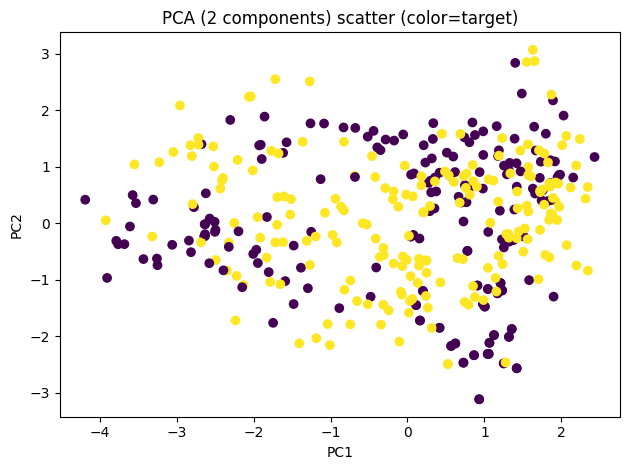

Saved PCA scatter to /content/analysis_plotss/pca_scatter.png


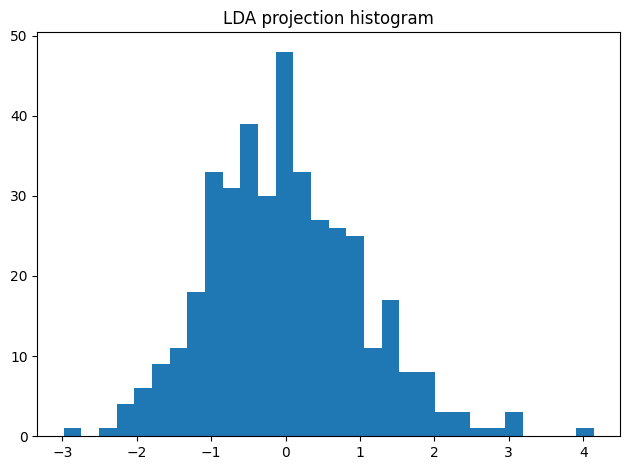

In [ ]:
# ======================================================
# Cell 12 - Dimensionality reduction: PCA and LDA (projections & plots)
# Explain: reduce dimensionality to visualize and capture main variance directions.
# ======================================================
pca = PCA(n_components=min(2, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratios:", pca.explained_variance_ratio_)

if X_pca.shape[1] >= 2:
    plt.figure()
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
    plt.title("PCA (2 components) scatter (color=target)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()
    plt.close()
    print("Saved PCA scatter to", PLOT_DIR/"pca_scatter.png")
else:
    print("PCA resulted in <2 components; skipping scatter plot.")

X_lda = None
try:
    lda_for_proj = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda_for_proj.fit_transform(X_scaled, y)
    plt.figure()
    plt.hist(X_lda[:,0], bins=30)
    plt.title("LDA projection histogram")
    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print("LDA projection failed:", e)





In [ ]:
from sklearn.linear_model import LogisticRegression

# ======================================================
# Cell 13 - Models: define models (GaussianNB, DecisionTree entropy, LDA classifier, KNN variants , Log reg)
# Explain: create model objects to be trained and evaluated.
# ======================================================
models = {
    "GaussianNB": GaussianNB(),
    "DecisionTree_entropy": DecisionTreeClassifier(criterion='entropy', random_state=42),
    "LDA_classifier": LinearDiscriminantAnalysis(),
    "KNN_euclidean": KNeighborsClassifier(n_neighbors=5, p=2),
    "KNN_manhattan": KNeighborsClassifier(n_neighbors=5, p=1),
    "KNN_minkowski_3": KNeighborsClassifier(n_neighbors=5, p=3),
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear')
}
print("Defined models:", list(models.keys()))

Defined models: ['GaussianNB', 'DecisionTree_entropy', 'LDA_classifier', 'KNN_euclidean', 'KNN_manhattan', 'KNN_minkowski_3', 'LogisticRegression']


In [ ]:
# ======================================================
# Cell 14 - Train/test split (80/20) and evaluate models on test set + 5-fold CV
# Explain: split data, train each model, compute accuracy/precision/recall/f1, and 5-fold CV mean.
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)

results = []
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        cv = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
        results.append({
            'model': name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'cv_mean_acc': cv.mean(),
            'confusion_matrix': cm.tolist()
        })
    except Exception as e:
        results.append({'model': name, 'error': str(e)})

results_df = pd.DataFrame(results)
if HAVE_TOOLS:
    tools.display_dataframe_to_user("Model evaluation (test split + 5-fold CV mean)", results_df)
else:
    print(results_df)

                  model  accuracy  precision  recall        f1  cv_mean_acc  \
0            GaussianNB    0.5375   0.533333   0.600  0.564706     0.239146   
1  DecisionTree_entropy    0.6750   0.659091   0.725  0.690476     0.517880   
2        LDA_classifier    0.6375   0.617021   0.725  0.666667     0.291867   
3         KNN_euclidean    0.6750   0.675000   0.675  0.675000     0.435063   
4         KNN_manhattan    0.6625   0.658537   0.675  0.666667     0.442627   
5       KNN_minkowski_3    0.7125   0.707317   0.725  0.716049     0.427563   
6    LogisticRegression    0.6750   0.652174   0.750  0.697674     0.304367   

       confusion_matrix  
0  [[19, 21], [16, 24]]  
1  [[25, 15], [11, 29]]  
2  [[22, 18], [11, 29]]  
3  [[27, 13], [13, 27]]  
4  [[26, 14], [13, 27]]  
5  [[28, 12], [11, 29]]  
6  [[24, 16], [10, 30]]  


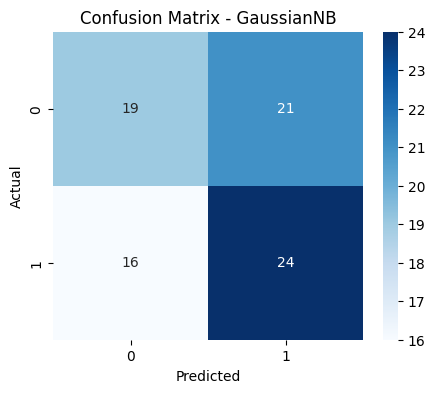

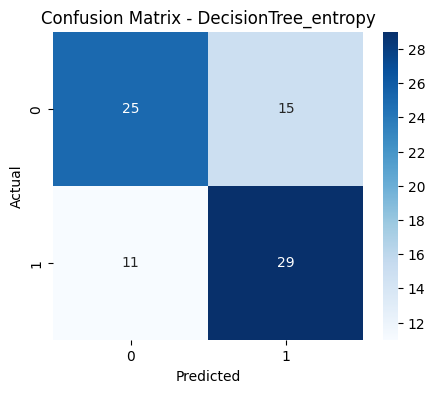

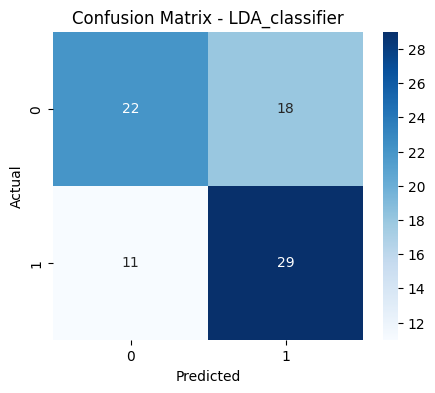

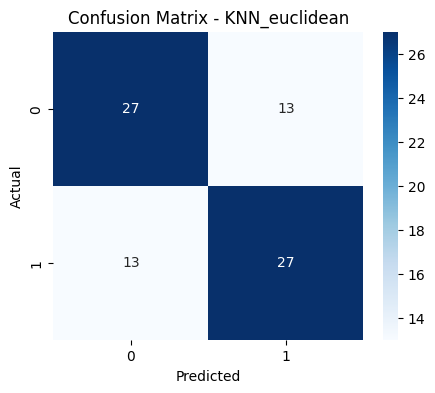

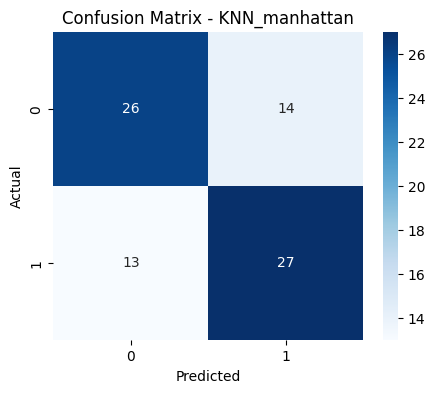

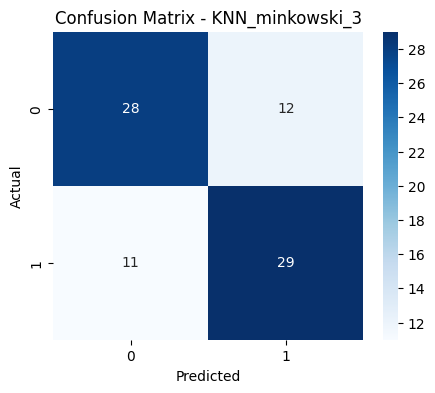

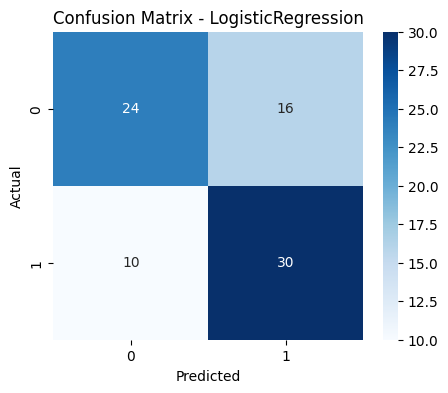

In [ ]:
# ======================================================
# Visualize confusion matrices for each model
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns

for result in results:
    if 'confusion_matrix' in result:
        cm = np.array(result['confusion_matrix'])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {result['model']}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

--- Linear Regression Model Evaluation ---
Mean Absolute Error (MAE): 6.3462
Mean Squared Error (MSE): 54.1891
R-squared (R2): 0.0113

--- 5-Fold Cross-Validation for Linear Regression ---
Mean MAE (CV): 6.3886 (Std: 0.2777)
Mean MSE (CV): 53.3086 (Std: 3.6953)
Mean R2 (CV): 0.0481 (Std: 0.0483)


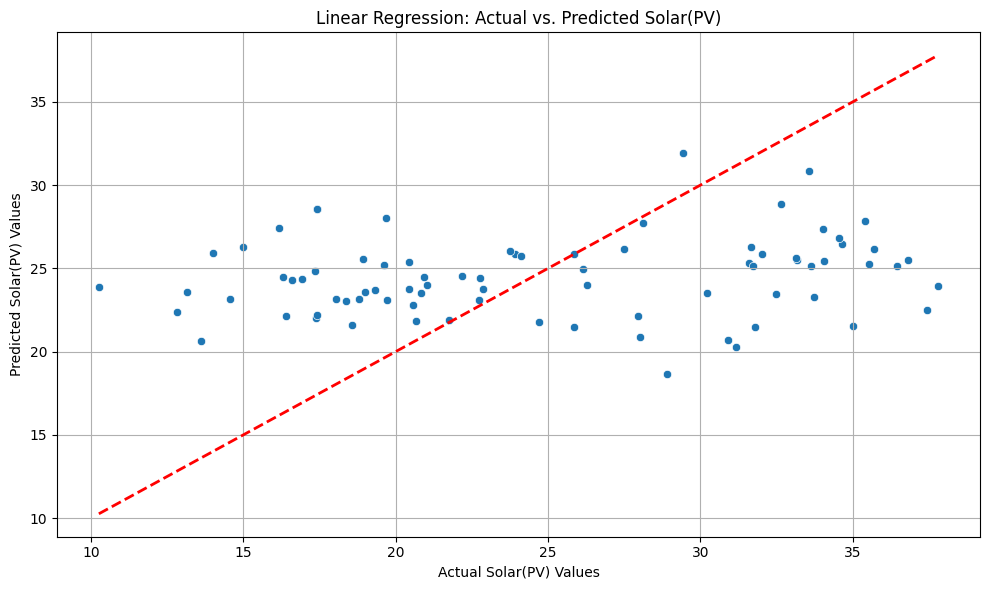

In [ ]:
#Linear Regression Implentation :
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define target and features for Linear Regression
y_reg = df[target_col]  # Use the original continuous 'Solar(PV)' column
X_reg = df[num_cols].drop(columns=[target_col], errors='ignore')

# Scale the features for regression
scaler_reg = StandardScaler()
X_scaled_reg = scaler_reg.fit_transform(X_reg)

# Train/test split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled_reg, y_reg, test_size=0.2, random_state=42
)

# Initialize and train the Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_reg, y_train_reg)

# Make predictions on the test set
y_pred_reg = linear_reg_model.predict(X_test_reg)

# Evaluate the Linear Regression model
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("--- Linear Regression Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Perform cross-validation for Linear Regression
kf_reg = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mae = -cross_val_score(linear_reg_model, X_scaled_reg, y_reg, cv=kf_reg, scoring='neg_mean_absolute_error')
cv_scores_mse = -cross_val_score(linear_reg_model, X_scaled_reg, y_reg, cv=kf_reg, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(linear_reg_model, X_scaled_reg, y_reg, cv=kf_reg, scoring='r2')

print("\n--- 5-Fold Cross-Validation for Linear Regression ---")
print(f"Mean MAE (CV): {cv_scores_mae.mean():.4f} (Std: {cv_scores_mae.std():.4f})")
print(f"Mean MSE (CV): {cv_scores_mse.mean():.4f} (Std: {cv_scores_mse.std():.4f})")
print(f"Mean R2 (CV): {cv_scores_r2.mean():.4f} (Std: {cv_scores_r2.std():.4f})")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2) # Ideal line
plt.xlabel("Actual Solar(PV) Values")
plt.ylabel("Predicted Solar(PV) Values")
plt.title("Linear Regression: Actual vs. Predicted Solar(PV)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()


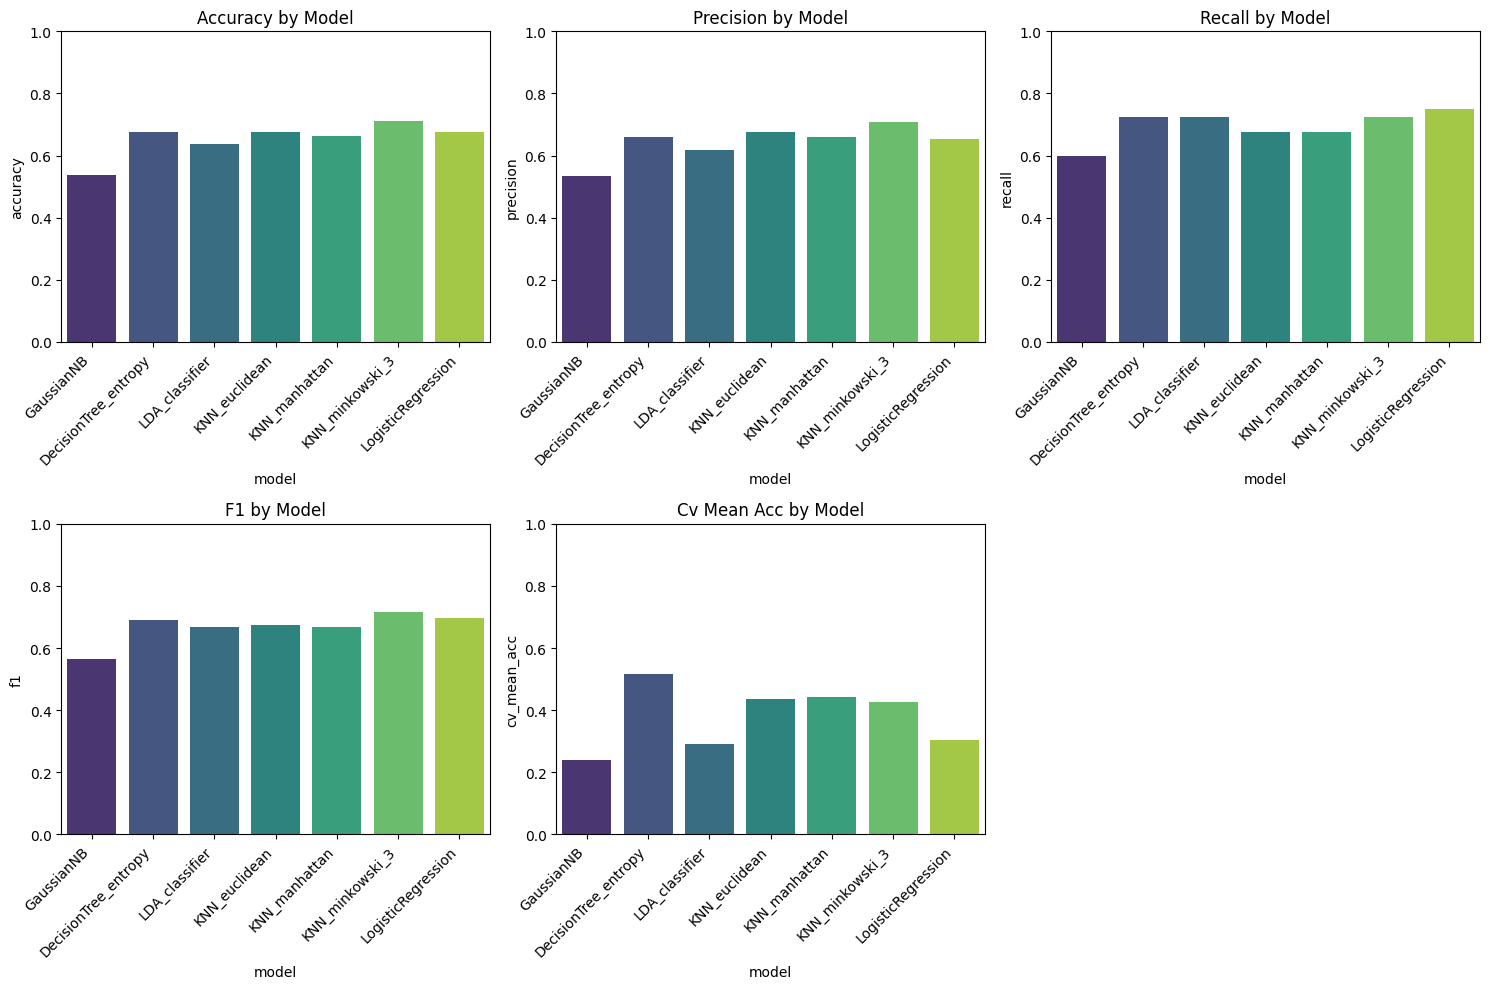

Visualized performance metrics for all models.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['accuracy', 'precision', 'recall', 'f1', 'cv_mean_acc']

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i + 1) # Arrange plots in a 2x3 grid
    sns.barplot(x='model', y=metric, data=results_df, palette='viridis')
    plt.title(f'{metric.replace("_", " ").title()} by Model')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1) # Assuming metrics are between 0 and 1
    plt.tight_layout()

plt.tight_layout()
plt.show()
plt.close()

print("Visualized performance metrics for all models.")

In [ ]:
# Hello shifo
# ======================================================
# Cell 15 - K-fold cross validation (10-fold) summary for each model
# Explain: compute mean and std of 10-fold CV accuracy for each model.
# ======================================================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_summary = {}
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
        cv_summary[name] = (scores.mean(), scores.std())
    except Exception as e:
        cv_summary[name] = (np.nan, str(e))

cv_df = pd.DataFrame.from_dict(cv_summary, orient='index', columns=['cv_mean_acc','cv_std'])
if HAVE_TOOLS:
    tools.display_dataframe_to_user("10-fold CV summary", cv_df.round(6))
else:
    print(cv_df.round(6))

                      cv_mean_acc    cv_std
GaussianNB               0.540769  0.075950
DecisionTree_entropy     0.681026  0.050657
LDA_classifier           0.580897  0.067503
KNN_euclidean            0.686282  0.051177
KNN_manhattan            0.670962  0.040399
KNN_minkowski_3          0.683782  0.055738
LogisticRegression       0.583397  0.070416


In [ ]:
from sklearn.preprocessing import label_binarize

# Convert Solar_PV into 3 classes (required for ROC/FROC)
y_class = pd.qcut(df['Solar(PV)'], q=3, labels=['Low','Medium','High'])

# Train/test split
from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_class, test_size=0.2, shuffle=False
)

# Binarize class labels for ROC/FROC (multiclass)
y_test_bin = label_binarize(y_test_clf, classes=['Low','Medium','High'])
n_classes = y_test_bin.shape[1]


SVD explained variance ratio (first 2 components):
[0.50350406 0.29398627]
Total explained variance by 2 components: 0.7975


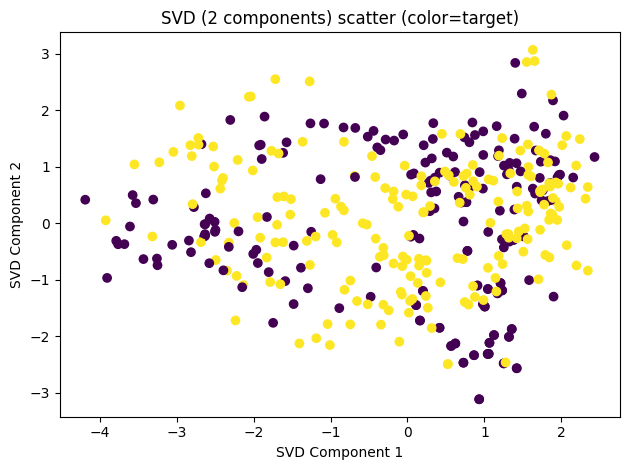

Saved SVD scatter to /content/analysis_plotss/svd_scatter.png


In [ ]:
from sklearn.decomposition import TruncatedSVD

# ======================================================
# Cell 16 - Dimensionality reduction: SVD
# Explain: Apply SVD to reduce the dimensionality of the features.
# ======================================================
n_components_svd = min(X_scaled.shape[1], 2) # Use 2 components for easy visualization
svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
X_svd = svd.fit_transform(X_scaled)

print(f"SVD explained variance ratio (first {n_components_svd} components):")
print(svd.explained_variance_ratio_)
print(f"Total explained variance by {n_components_svd} components: {svd.explained_variance_ratio_.sum():.4f}")

if n_components_svd >= 2:
    plt.figure()
    plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y)
    plt.title("SVD (2 components) scatter (color=target)")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.tight_layout()
    plt.show()
    plt.close()
    print("Saved SVD scatter to", PLOT_DIR/"svd_scatter.png")
else:
    print("SVD resulted in <2 components; skipping scatter plot.")

Model evaluation with SVD features (test split + 5-fold CV mean):
                  model  accuracy_svd  precision_svd  recall_svd    f1_svd  \
0            GaussianNB        0.5500       0.534483       0.775  0.632653   
1  DecisionTree_entropy        0.5625       0.558140       0.600  0.578313   
2        LDA_classifier        0.5125       0.510638       0.600  0.551724   
3         KNN_euclidean        0.6625       0.644444       0.725  0.682353   
4         KNN_manhattan        0.6750       0.675000       0.675  0.675000   
5       KNN_minkowski_3        0.6500       0.625000       0.750  0.681818   
6    LogisticRegression        0.5125       0.510638       0.600  0.551724   

   cv_mean_acc_svd  confusion_matrix_svd  
0         0.304146   [[13, 27], [9, 31]]  
1         0.472785  [[21, 19], [16, 24]]  
2         0.211329  [[17, 23], [16, 24]]  
3         0.437247  [[24, 16], [11, 29]]  
4         0.434715  [[27, 13], [13, 27]]  
5         0.449873  [[22, 18], [10, 30]]  
6       

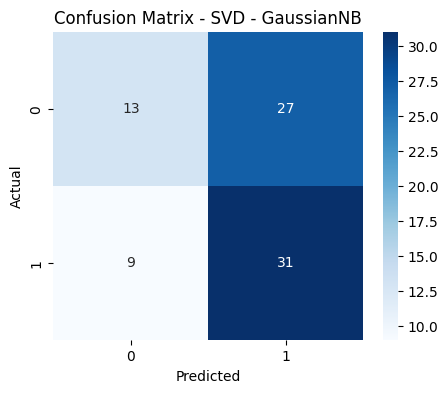

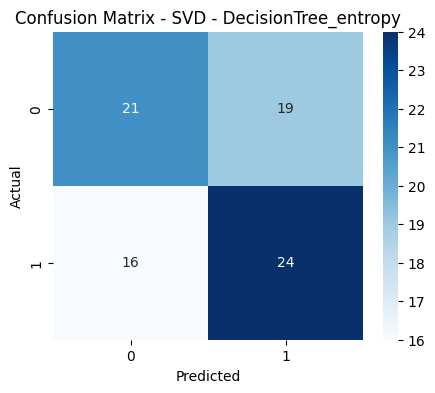

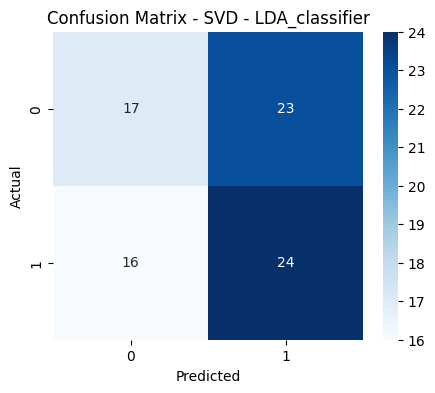

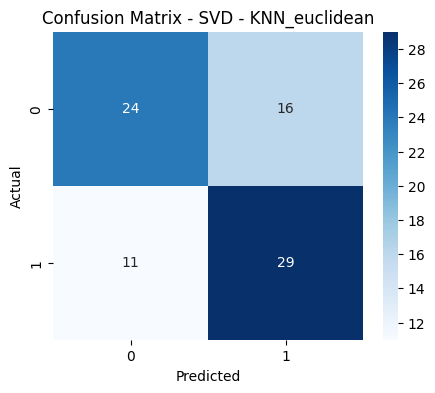

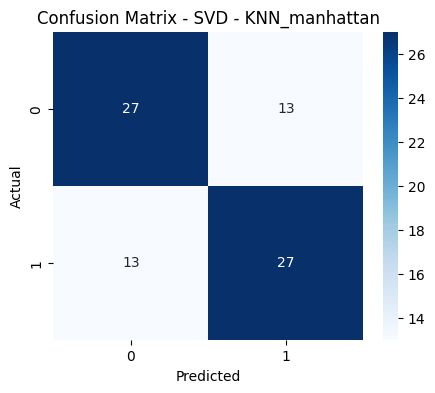

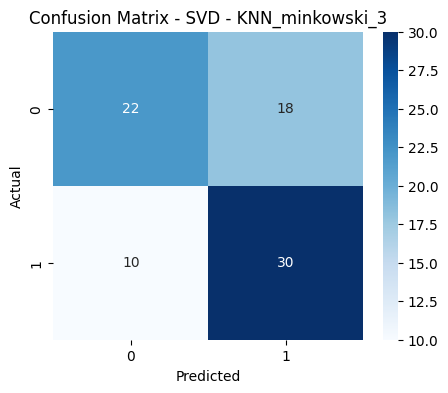

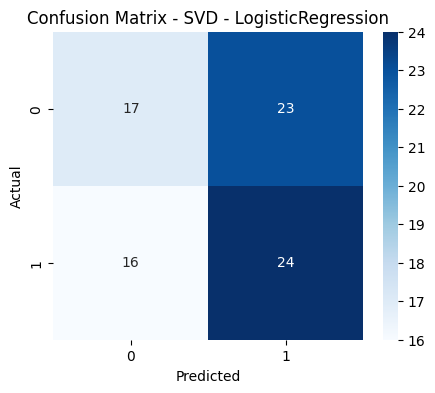

In [ ]:
# ======================================================
# Cell 17 - Train/test split and evaluate models with SVD features
# Explain: Re-evaluate models using SVD-transformed features.
# ======================================================
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)

results_svd = []
for name, model in models.items(): # Use the same models defined earlier
    try:
        model.fit(X_train_svd, y_train_svd)
        y_pred_svd = model.predict(X_test_svd)
        acc_svd = accuracy_score(y_test_svd, y_pred_svd)
        prec_svd = precision_score(y_test_svd, y_pred_svd, zero_division=0)
        rec_svd = recall_score(y_test_svd, y_pred_svd, zero_division=0)
        f1_svd = f1_score(y_test_svd, y_pred_svd, zero_division=0)
        cm_svd = confusion_matrix(y_test_svd, y_pred_svd)
        cv_svd = cross_val_score(model, X_svd, y, cv=5, scoring='accuracy')
        results_svd.append({
            'model': name,
            'accuracy_svd': acc_svd,
            'precision_svd': prec_svd,
            'recall_svd': rec_svd,
            'f1_svd': f1_svd,
            'cv_mean_acc_svd': cv_svd.mean(),
            'confusion_matrix_svd': cm_svd.tolist()
        })
    except Exception as e:
        results_svd.append({'model': name, 'error': str(e)})

results_df_svd = pd.DataFrame(results_svd)

print("Model evaluation with SVD features (test split + 5-fold CV mean):")
if HAVE_TOOLS:
    tools.display_dataframe_to_user("Model evaluation with SVD features", results_df_svd)
else:
    print(results_df_svd)

for result in results_svd:
    if 'confusion_matrix_svd' in result:
        cm = np.array(result['confusion_matrix_svd'])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - SVD - {result['model']}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        plt.close()

In [ ]:
print(f"Shape of X_scaled: {X_scaled.shape}")
print(f"First 5 rows of X_scaled:\n{X_scaled[:5]}")
print(f"\nShape of y: {y.shape}")
print(f"First 5 entries of y: {y[:5]}")

Shape of X_scaled: (398, 5)
First 5 rows of X_scaled:
[[ 0.44524307 -0.61311171 -0.98191335 -1.77443609  0.12108539]
 [ 0.61441067 -0.30959218 -0.89981435 -1.41529777 -0.59286994]
 [ 0.83506406 -0.60187025 -1.14611135 -0.53740408 -0.59286994]
 [ 0.78357827 -1.33256541 -1.39240836 -0.85663815 -0.59286994]
 [ 0.6879618  -2.00705326 -1.55660636 -0.29797853  0.12108539]]

Shape of y: (398,)
First 5 entries of y: [0 0 0 0 0]


X_train shape: (318, 5), y_train shape: (318,)
X_test shape: (80, 5), y_test shape: (80,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

FNN Model training complete.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

--- FNN Model Evaluation ---
Accuracy: 0.6875
Precision: 0.6596
Recall: 0.7750
F1-Score: 0.7126


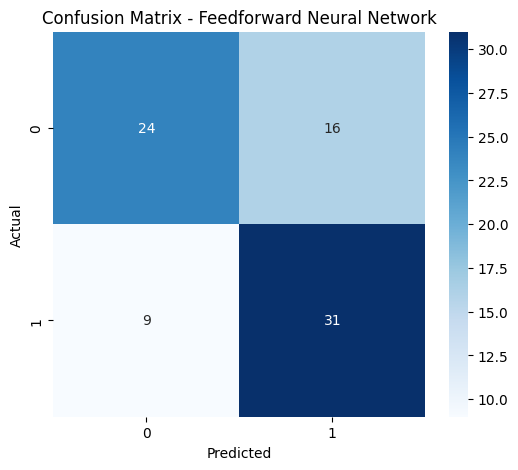


Updated Model Evaluation Results (including FNN):
                        model  accuracy  precision  recall        f1  \
0                  GaussianNB    0.5375   0.533333   0.600  0.564706   
1        DecisionTree_entropy    0.6750   0.659091   0.725  0.690476   
2              LDA_classifier    0.6375   0.617021   0.725  0.666667   
3               KNN_euclidean    0.6750   0.675000   0.675  0.675000   
4               KNN_manhattan    0.6625   0.658537   0.675  0.666667   
5             KNN_minkowski_3    0.7125   0.707317   0.725  0.716049   
6          LogisticRegression    0.6750   0.652174   0.750  0.697674   
7  Feedforward Neural Network    0.6875   0.659574   0.775  0.712644   

   cv_mean_acc      confusion_matrix  
0     0.239146  [[19, 21], [16, 24]]  
1     0.517880  [[25, 15], [11, 29]]  
2     0.291867  [[22, 18], [11, 29]]  
3     0.435063  [[27, 13], [13, 27]]  
4     0.442627  [[26, 14], [13, 27]]  
5     0.427563  [[28, 12], [11, 29]]  
6     0.304367  [[24, 16], 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 2. Split X_scaled and y into training and testing sets
# X_scaled and y are already defined from previous steps
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# 3. Define the FNN model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 4. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Train the FNN model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Using a small validation split to monitor training
    verbose=0 # Suppress verbose output for cleaner notebook
)
print("FNN Model training complete.")

# 6. Make predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred_fnn = (y_pred_proba > 0.5).astype(int)

# 7. Calculate accuracy, precision, recall, and F1-score
acc_fnn = accuracy_score(y_test, y_pred_fnn)
prec_fnn = precision_score(y_test, y_pred_fnn, zero_division=0)
rec_fnn = recall_score(y_test, y_pred_fnn, zero_division=0)
f1_fnn = f1_score(y_test, y_pred_fnn, zero_division=0)

print("\n--- FNN Model Evaluation ---")
print(f"Accuracy: {acc_fnn:.4f}")
print(f"Precision: {prec_fnn:.4f}")
print(f"Recall: {rec_fnn:.4f}")
print(f"F1-Score: {f1_fnn:.4f}")

# 8. Generate and display the confusion matrix
cm_fnn = confusion_matrix(y_test, y_pred_fnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_fnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Feedforward Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()

# Optionally, add FNN results to the overall results_df for comparison
fnn_result = {
    'model': 'Feedforward Neural Network',
    'accuracy': acc_fnn,
    'precision': prec_fnn,
    'recall': rec_fnn,
    'f1': f1_fnn,
    'cv_mean_acc': np.nan, # CV for FNN would require more advanced implementation
    'confusion_matrix': cm_fnn.tolist()
}

# Convert results_df to list of dicts, append, and convert back to DataFrame
all_results = results_df.to_dict('records')
all_results.append(fnn_result)
results_df = pd.DataFrame(all_results)

print("\nUpdated Model Evaluation Results (including FNN):")
if HAVE_TOOLS:
    tools.display_dataframe_to_user("All Model Evaluation (test split + 5-fold CV mean)", results_df)
else:
    print(results_df)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Reshape

# 1. Reshape the X_scaled data into a 3D array (samples, timesteps, features)
X_rnn = np.expand_dims(X_scaled, axis=1)

print(f"Original X_scaled shape: {X_scaled.shape}")
print(f"Reshaped X_rnn shape: {X_rnn.shape}")

Original X_scaled shape: (398, 5)
Reshaped X_rnn shape: (398, 1, 5)


X_train_rnn shape: (318, 1, 5), y_train_rnn shape: (318,)
X_test_rnn shape: (80, 1, 5), y_test_rnn shape: (80,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

RNN Model training complete.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

--- RNN Model Evaluation ---
Accuracy: 0.6875
Precision: 0.6596
Recall: 0.7750
F1-Score: 0.7126


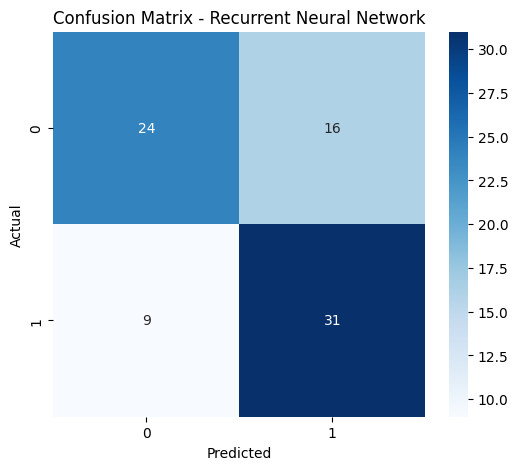


Updated Model Evaluation Results (including RNN):
                        model  accuracy  precision  recall        f1  \
0                  GaussianNB    0.5375   0.533333   0.600  0.564706   
1        DecisionTree_entropy    0.6750   0.659091   0.725  0.690476   
2              LDA_classifier    0.6375   0.617021   0.725  0.666667   
3               KNN_euclidean    0.6750   0.675000   0.675  0.675000   
4               KNN_manhattan    0.6625   0.658537   0.675  0.666667   
5             KNN_minkowski_3    0.7125   0.707317   0.725  0.716049   
6          LogisticRegression    0.6750   0.652174   0.750  0.697674   
7  Feedforward Neural Network    0.6875   0.659574   0.775  0.712644   
8    Recurrent Neural Network    0.6875   0.659574   0.775  0.712644   

   cv_mean_acc      confusion_matrix  
0     0.239146  [[19, 21], [16, 24]]  
1     0.517880  [[25, 15], [11, 29]]  
2     0.291867  [[22, 18], [11, 29]]  
3     0.435063  [[27, 13], [13, 27]]  
4     0.442627  [[26, 14], [13, 2

In [ ]:
from sklearn.model_selection import train_test_split

# 3. Split the reshaped data and y into training and testing sets
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train_rnn shape: {X_train_rnn.shape}, y_train_rnn shape: {y_train_rnn.shape}")
print(f"X_test_rnn shape: {X_test_rnn.shape}, y_test_rnn shape: {y_test_rnn.shape}")

# 4. Define the Sequential RNN model
rnn_model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 5. Compile the RNN model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

# 6. Train the RNN model
history_rnn = rnn_model.fit(
    X_train_rnn, y_train_rnn,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
print("RNN Model training complete.")

# 7. Make predictions on the test set
y_pred_proba_rnn = rnn_model.predict(X_test_rnn)
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)

# 8. Calculate accuracy, precision, recall, and F1-score
acc_rnn = accuracy_score(y_test_rnn, y_pred_rnn)
prec_rnn = precision_score(y_test_rnn, y_pred_rnn, zero_division=0)
rec_rnn = recall_score(y_test_rnn, y_pred_rnn, zero_division=0)
f1_rnn = f1_score(y_test_rnn, y_pred_rnn, zero_division=0)

print("\n--- RNN Model Evaluation ---")
print(f"Accuracy: {acc_rnn:.4f}")
print(f"Precision: {prec_rnn:.4f}")
print(f"Recall: {rec_rnn:.4f}")
print(f"F1-Score: {f1_rnn:.4f}")

# 9. Generate and display the confusion matrix
cm_rnn = confusion_matrix(y_test_rnn, y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Recurrent Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()

# 10. Add RNN results to the overall results_df for comparison
rnn_result = {
    'model': 'Recurrent Neural Network',
    'accuracy': acc_rnn,
    'precision': prec_rnn,
    'recall': rec_rnn,
    'f1': f1_rnn,
    'cv_mean_acc': np.nan, # CV for RNN would require more advanced implementation
    'confusion_matrix': cm_rnn.tolist()
}

# Convert results_df to list of dicts, append, and convert back to DataFrame
# Check if results_df from previous cells contains FNN results to avoid duplication
if 'Feedforward Neural Network' not in results_df['model'].values:
    all_results = results_df.to_dict('records')
else:
    # If FNN was added, we need to use the combined results_df before adding RNN
    # Assuming the current results_df is the one updated with FNN
    all_results = results_df.to_dict('records')

all_results.append(rnn_result)
results_df = pd.DataFrame(all_results)

print("\nUpdated Model Evaluation Results (including RNN):")
if HAVE_TOOLS:
    tools.display_dataframe_to_user("All Model Evaluation (test split + 5-fold CV mean)", results_df)
else:
    print(results_df)


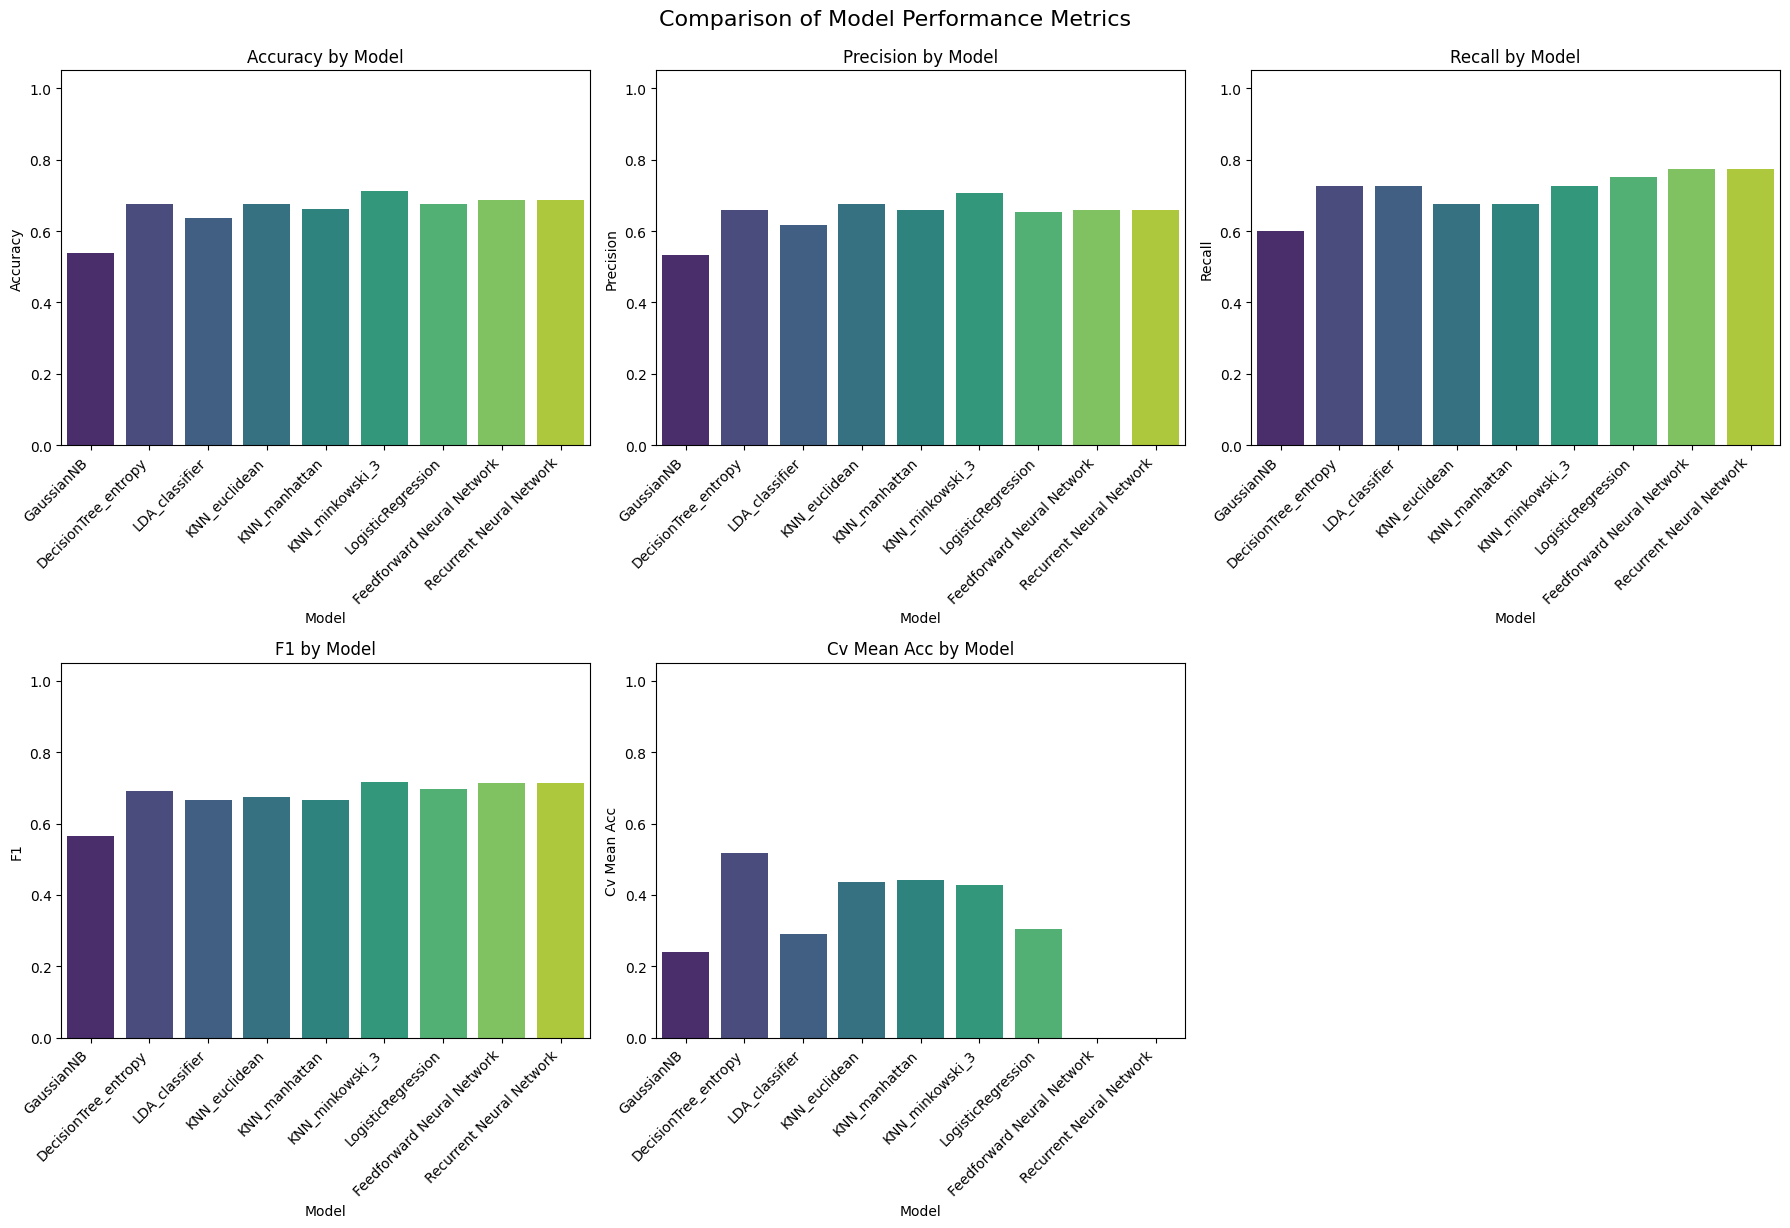

Visualized performance metrics for all models.

Confusion Matrices for Neural Network Models:


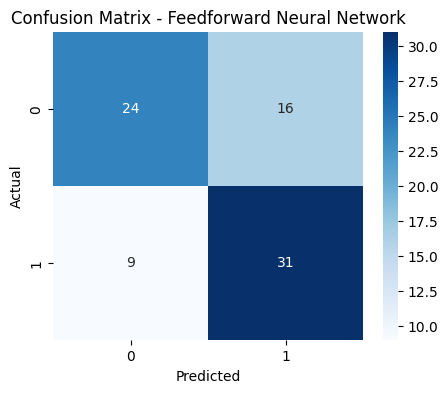

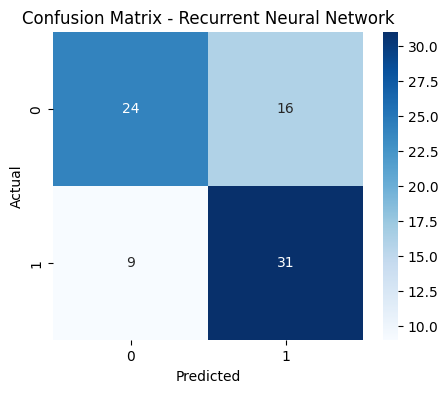

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'cv_mean_acc']

# Plotting performance metrics
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i + 1) # Arrange plots in a 2x3 grid
    # Ensure 'model' column is treated as categorical for consistent ordering
    sns.barplot(x='model', y=metric, data=results_df, palette='viridis', order=results_df['model'])
    plt.title(f'{metric.replace("_", " ").title()} by Model')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05) # Ensure y-axis goes slightly above 1 for visibility, and starts at 0
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Model')

plt.tight_layout()
plt.suptitle('Comparison of Model Performance Metrics', y=1.02, fontsize=16)
plt.show()
plt.close()

print("Visualized performance metrics for all models.")

# Display confusion matrices for FNN and RNN
nn_models = ['Feedforward Neural Network', 'Recurrent Neural Network']

print("\nConfusion Matrices for Neural Network Models:")
for result in results_df.to_dict('records'): # Convert to list of dicts to iterate
    if result['model'] in nn_models:
        if 'confusion_matrix' in result and result['confusion_matrix'] is not np.nan:
            cm = np.array(result['confusion_matrix'])
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"Confusion Matrix - {result['model']}")
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()
            plt.close()
        else:
            print(f"Confusion matrix not available for {result['model']}")


In [ ]:
nn_comparison_df = results_df[results_df['model'].isin(['Feedforward Neural Network', 'Recurrent Neural Network'])]

print("Neural Network Performance Comparison:")
if HAVE_TOOLS:
    tools.display_dataframe_to_user("FNN vs RNN Performance", nn_comparison_df)
else:
    print(nn_comparison_df)

Neural Network Performance Comparison:
                        model  accuracy  precision  recall        f1  \
7  Feedforward Neural Network    0.6875   0.659574   0.775  0.712644   
8    Recurrent Neural Network    0.6875   0.659574   0.775  0.712644   

   cv_mean_acc     confusion_matrix  
7          NaN  [[24, 16], [9, 31]]  
8          NaN  [[24, 16], [9, 31]]  
